 Temperature not specified!
 Proceeding with default T = 300 K


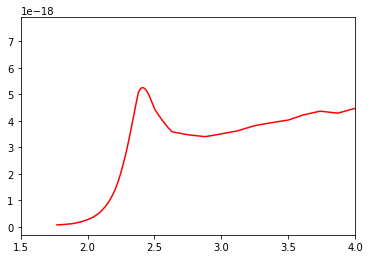

47
7.528880293606375e-18
2.1175587793896946e-07


In [51]:
from wptherml.wpml import multilayer
from matplotlib import pyplot as plt
from wptherml.datalib import datalib
import numpy as np
from numpy import linalg as LA
import math

structure = {

        'Material_List': ['Air', 'Au', 'Air'],
        'Thickness_List': [0,  200e-9, 0],
        'Lambda_List': [200e-9, 700e-9, 2000],
     
        }

### create the silver object - call it sphere for no particular reason
sphere = multilayer(structure)
### get the refractive index of Ag (since it is layer 1 based on the structure above)
n_Ag = sphere.layer_ri(1)
### get the dielectric function of Ag
eps_Ag = n_Ag * n_Ag

'''Lets compute the Mie theory absorption of a 3 nm Ag particle in water, which 
   has refractive index = 1.33, here!'''
r = 3e-9 ### fill in radius here, use meters!
eps_s =  1.33 ### fill in dielectric function of water here!
quotient = (eps_Ag - eps_s)/(eps_Ag + 2*eps_s) ### compute the quotient whose Imaginary part you need from Mie theory expression here
alpha = 4*np.pi*r**3 * quotient
pre = 2*np.pi/sphere.lambda_array ### compute pre-factor that depends on wavelength and radius here! 
sigma_abs = pre*np.imag(alpha) ### compute full absorption spectrum here!


plt.plot(1240/(sphere.lambda_array*1e9), sigma_abs, 'red')###
#plt.plot(1240/(sphere.lambda_array*1e9), np.real(alpha), 'red')
#plt.plot(1240/(sphere.lambda_array*1e9), np.imag(alpha), 'blue')
plt.xlim(1.5, 4)
plt.show()

lidx = np.argmax(sigma_abs)
print(lidx)
print(sigma_abs[lidx])
print(sphere.lambda_array[lidx])
###Example code for getting the dielectric function of Ag
###Get RI of silver (layer 1)of sphere object
Ag_RI = sphere.layer_ri(1)
###dielectric function is square of recractive index
Ag_eps = Ag_RI * Ag_RI

In [52]:
def Euler (H0, mu, Vint, gamma, D, h, t, tau):  
###Defined Hamiltonian at the current time    
    H = H0- EField(t, tau) * mu
    ### Define the time derivarive of our density matrix at the current time
    ### by evaluating the Liouville-Lindblad equation
    Ddot = Liouville(H,D) + Lindblad(D, gamma)
    ###
    Dnew = D + h*Ddot
    return Dnew
    
def Lindblad(D, gamma):
    dim = len(D)
    LD = np.zeros_like(D)
    ### need |g><g|
    bra_1 = CreateBas(dim, 0)
    gm = Form_Rho(bra_1)
    
    for k in range(1,dim):
        bra_k = CreateBas(dim, k)
        km = Form_Rho(bra_k)
        
        ### first term 2*gam*<k|D|k>|g><g|
        t1 = 2*gamma*D[k][k]*gm
        ### second term is |k><k|*D
        t2 = np.dot(km,D)
        ### third term is  D*|k><k|
        t3 = np.dot(D, km)
        LD = LD + t1 - gamma*t2 - gamma*t3
        
    return LD

### Take commutator of H and D to give Ddot
def Liouville(H, D):
    ci = 0.+1j
    return -ci*(np.dot(H,D) - np.dot(D, H))

def EField(t, tau):
    Ef = 0
    if t<tau:
        Ef = 0.001*np.sin(t*np.pi/tau)*np.sin(t*np.pi/tau)*np.sin(0.1192*t)
    return Ef

def Form_Rho(Psi):

    D = np.outer(Psi,np.conj(Psi))
    return D


### Creates basis vector for state k
### k=0 -> ground state, k=1 -> first excited-state, etc
def CreateBas(dim, k):
    bas = np.zeros(dim)
    bas[k] = 1
    return bas



In [53]:
def RK4(H0, mu, Vint, gamma, D, h, t, tau):
    k1 = np.zeros_like(D)
    k2 = np.zeros_like(D)
    k3 = np.zeros_like(D)
    k4 = np.zeros_like(D)
    D1 = np.zeros_like(D)
    D2 = np.zeros_like(D)
    D3 = np.zeros_like(D)
    D4 = np.zeros_like(D)
    Df = np.zeros_like(D)
    
    ### Get k1
    H1 = H0 - EField(t, tau)*mu + Vint
    D1 = D    
    k1 = h*Liouville(H1,D1) + h*Lindblad(D1, gamma)
    
    ## Update H and D and get k2
    H2 = H0 - EField(t+h/2, tau)*mu + Vint
    D2 = D+k1/2.
    k2 = h*Liouville(H2, D2) + h*Lindblad(D2, gamma)
    
    ### UPdate H and D and get k3
    H3 = H2
    D3 = D+k2/2
    k3 = h*Liouville(H3, D3) + h*Lindblad(D3, gamma) 
    
    ### Update H and D and get K4
    H4 = H0 - EField(t+h, tau)*mu + Vint
    D4 = D+k3
    k4 = h*Liouville(H4, D4) + h*Lindblad(D4, gamma)
    
    Df = D + (1/6.)*(k1 + 2.*k2 + 2*k3 + k4)
    return Df

0.0015707963267948967


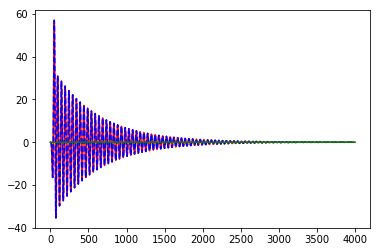

In [54]:
### Set up some parameters for the quantum dynamics simulation
dt = 0.1
tau = 100 #150.
gamma = 0.0017
eps0 = 8.854e-12
#mu_au_to_si = 8.47835326e-30
#E_au_to_si = 5.14220652e11
mu_z = 58.

### Create some arrays
MUZ= np.zeros((2,2),dtype=complex)
Vint = np.zeros((2,2),dtype=complex)
### Density matrix for RK4 updates
D_RK4 = np.zeros((2,2),dtype=complex)
### Density matrix for Euler updates
D_EU  = np.zeros((2,2),dtype=complex)
H0 = np.zeros((2,2))

### initialize values of the arrays for Hamiltonian and Density matrices
H0[0][0] = 0.1275
D_RK4[0][0] = 1.+0j
D_EU[0][0] = 1.+0j
MUZ[0][1] = mu_z
MUZ[1][0] = mu_z

### create arrays for time-dependent quantities
Nsteps = 40000
ez = np.zeros(Nsteps)
### array for mu(t) for RK4 updates
mu_of_t_rk4 = np.zeros(Nsteps,dtype=complex)
### array for mu(t) for Euler updates
mu_of_t_eu = np.zeros(Nsteps,dtype=complex)
time = np.zeros(Nsteps)
energy = np.zeros(Nsteps)


### Run the dynamics
for i in range(0,Nsteps):
    ### reciprocal axis
    energy[i] = np.pi*2*(i+1)/(Nsteps*dt)
    ### time access
    time[i] = i*dt
    ### time-dependent electric field
    ez[i] = EField(i*dt, tau)
    ### update to the Density matrix using RK4
    D_RK4 = RK4(H0, MUZ, Vint, gamma, D_RK4, dt, dt*i, tau)
    D_EU = Euler(H0, MUZ, Vint, gamma, D_RK4, dt, dt*i, tau)
    ### Update to mu(t) using RK4
    DMU_RK4 = np.matmul(D_RK4, MUZ)
    DMU_EU = np.matmul(D_EU, MUZ)
    mu_of_t_rk4[i] = (DMU_RK4[0][0] + DMU_RK4[1][1])
    mu_of_t_eu[i] = (DMU_EU[0][0] + DMU_EU[1][1])
    ### add update using Euler step!!!

print(energy[0])
plt.plot(time, mu_of_t_eu, 'red', time, mu_of_t_rk4, 'b--', time, ez, 'green')
plt.show()

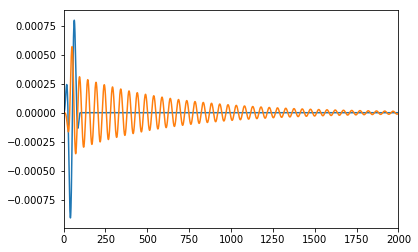

In [55]:
plt.plot(time, ez, time ,mu_of_t_rk4/100000)
plt.xlim(0,2000)
plt.show()

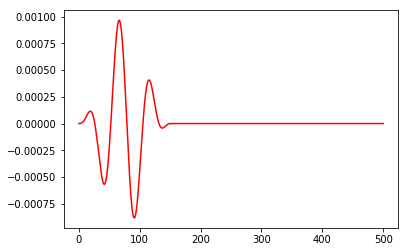

In [64]:
# returns func of omega val
def fourier_transform(omega, t_array, f_of_t):
    f_of_o = np.zeros(len(omega),dtype = complex)
    ### imaginary values
    ci = 0+1j
    
   
    N = len(t_array)
    
    M = len(f_of_o)
    ##omega loop
    dt = t_array[1]- t_array[0]
    for i in range(0,M):
        w = omega[i]
        som = 0+0j
        ### loop for time
        for j in range(0,N):
            some = som + np.exp(ci*w*t_array[j])*f_of_t[j]*dt
            
        f_of_o[i] = som
        
    return f_of_o

ta = np.linspace(0.1,dt*5000,5000)
en = np.pi*2/ta
sig = np.zeros_like(ta) 
for i in range (0, len(ta)):
    if (ta[i]<150):
        sig[i] = 0.001*np.sin(ta[i]*np.pi/150)*np.sin(ta[i]*np.pi/150)*np.sin(0.1192*ta[i])

    else:
        sig[i] = 0.
    
mu_of_w = fourier_transform(en, ta, sig)

plt.plot(ta, sig, 'red')
plt.show()



        
        